In [1]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

C:\Users\tony_\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\tony_\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
C:\Users\tony_\anaconda3\lib\site-packages\dask\dataframe\utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


### Meta Data

In this project, we are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud. The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

**Transaction Table**

- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: “both addresses are for purchaser; addr1 as billing region; addr2 as billing country”
- **dist: distance**; "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- **P_ and (R__) emaildomain**: purchaser and recipient email domain (certain transactions don't need recipient, so R_emaildomain is null.)
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. (maybe counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.)
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.


**Identity Table**

- **DeviceType**
- **DeviceInfo**
- **id_01 - id_38**
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
- The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement

### Load Data

In [2]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='right')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]

train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]


print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 590540 rows & 434 columns.


Due to the abundance of transaction data as compared to identity data, we have chosen to utilize transaction data as the primary predictors in our analysis. To achieve this, we have performed a left join on the "TransactionID" column, merging the two dataframes. This merge retains all the records from the transaction dataframe and adds matched records from the identity dataframe. Consequently, our final dataset is a merged dataset containing 590540 rows and 434 columns.

In [3]:
# release data from those four
del train_transaction
del train_identity

In [4]:
train_df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

We observed significantly less fraud data in our dataset. In order to create a model that predicts both class accurately, we decide to balance the labels by downsampling, as oversampling would lead to overfitting. 

In [5]:
train_is_fraud = train_df[train_df['isFraud']==1].sample(replace=False, n=len(train_df[train_df['isFraud']==1]))
train_is_not_fraud = train_df[train_df['isFraud']==0].sample(replace=False, n=len(train_is_fraud))
train_df = pd.concat([train_is_fraud, train_is_not_fraud])

In [6]:
train_df.isFraud.value_counts()

1    20663
0    20663
Name: isFraud, dtype: int64

### EDA

Because we have a total of 434 columns, it is difficult to check correlation between each column and the predicted label. Therefore, we used our intuition and domain knowledge to select a subset of features that we thought could be effective in predicting whether or not the transaction is fraudulent.

- Transaction Time

- Transaction Amount

- Card information

- Billing Address

- Email Domains

- Device Type

- Device Info

In [7]:
#Transform TransactionDT into Hour, Day of Week
def convert_hour(x):
    return (x // (1 * 60 * 60)) % 24

def convert_day_of_week(x):
    return (x // (24 * 60 * 60)) % 7

train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)

#### Fraud Percentage By Hour

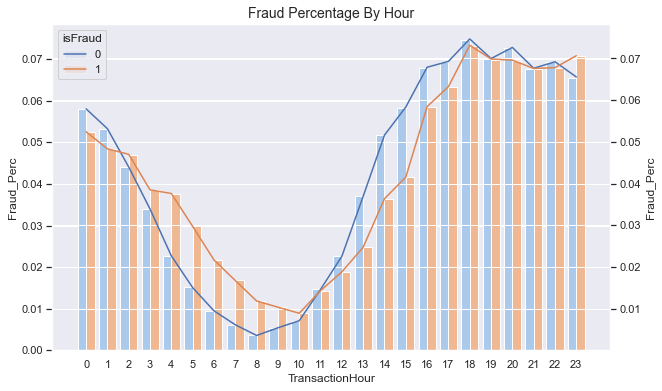

In [8]:
fraud_hour_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionHour'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_hour_perc_df = fraud_hour_perc / fraud_hour_perc.groupby(level=0).sum()
fraud_hour_perc_df = fraud_hour_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Hour', fontsize=14)
ax1 = sns.barplot(x="TransactionHour", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_hour_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionHour', y='Fraud_Perc', data = fraud_hour_perc_df, sort=False, hue="isFraud")
plt.show()

#### Fraud Percentage by Day of Week

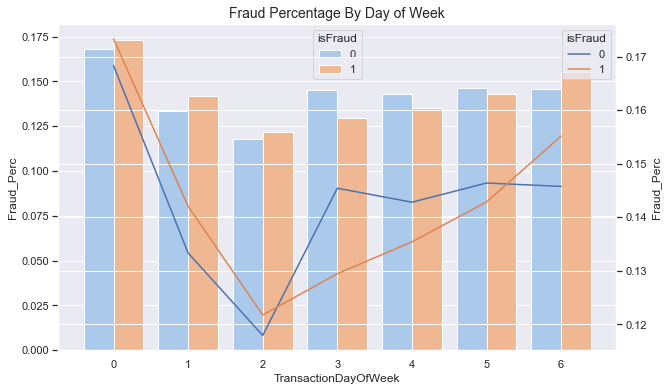

In [9]:
fraud_dow_perc = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionDayOfWeek'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_dow_perc_df = fraud_dow_perc / fraud_dow_perc.groupby(level=0).sum()
fraud_dow_perc_df = fraud_dow_perc_df.reset_index()
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_title('Fraud Percentage By Day of Week', fontsize=14)
ax1 = sns.barplot(x="TransactionDayOfWeek", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_dow_perc_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionDayOfWeek', y='Fraud_Perc', data = fraud_dow_perc_df, sort=False, hue="isFraud")
plt.show()

### Transaction Amount

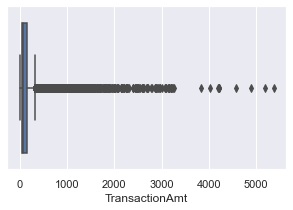

In [10]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.boxplot(train_df['TransactionAmt'])

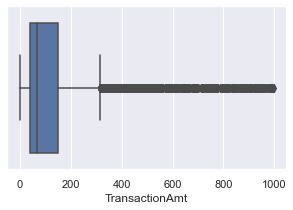

In [11]:
#Remove outliers
fig, ax = plt.subplots(figsize=(5,3))
transaction_amount = train_df[train_df['TransactionAmt'] < 1000]['TransactionAmt']
ax = sns.boxplot(transaction_amount)

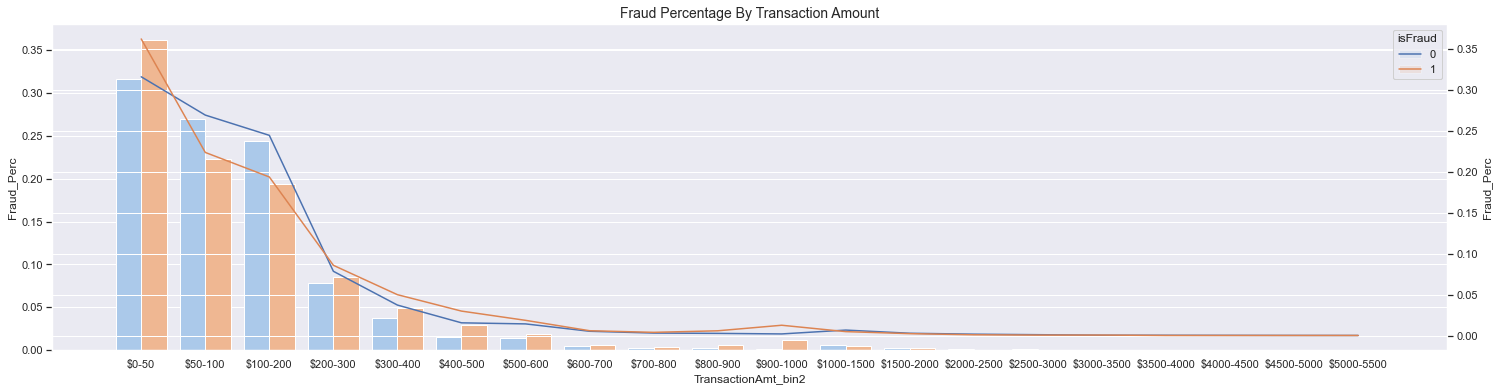

In [12]:
def convert_to_bin_amt(x):
    if x < 50:
        return '$0-50'
    elif x < 100:
        return '$50-100'
    elif x < 200:
        return '$100-200'
    elif x < 300:
        return '$200-300'
    elif x < 400:
        return '$300-400'
    elif x < 500:
        return '$400-500'
    elif x < 600:
        return '$500-600'
    elif x < 700:
        return '$600-700'
    elif x < 800:
        return '$700-800'
    elif x < 900:
        return '$800-900'
    elif x < 1000:
        return '$900-1000'
    elif x < 1500:
        return '$1000-1500'
    elif x < 2000:
        return '$1500-2000'
    elif x < 2500:
        return '$2000-2500'
    elif x < 3000:
        return '$2500-3000'
    elif x < 3500:
        return '$3000-3500'
    elif x < 4000:
        return '$3500-4000'
    elif x < 4500:
        return '$4000-4500'
    elif x < 5000:
        return '$4500-5000'
    elif x < 5500:
        return '$5000-5500'
    elif x < 6000:
        return '$5500-6000'
    elif x < 6500:
        return '$6000-6500'
    elif x < 7000:
        return '$6500-7000'
    elif x < 7500:
        return '$7000-7500'
    elif x < 8000:
        return '$7500-8000'
    elif x < 8500:
        return '$8000-8500'
    elif x < 9000:
        return '$8500-9000'
    elif x < 9500:
        return '$9000-9500'
    elif x < 10000:
        return '$9500-10000'
    else:
        return '$10000-+'
    
train_df['TransactionAmt_bin2'] = train_df['TransactionAmt'].apply(convert_to_bin_amt)
fraud_amount = pd.DataFrame(train_df.groupby(['isFraud', 'TransactionAmt_bin2'])['isFraud'].count()).rename(columns={"isFraud": "Fraud_Perc"})
fraud_amount_df = fraud_amount / fraud_amount.groupby(level=0).sum()
fraud_amount_df = fraud_amount_df.reset_index()
fraud_amount_df['index_2'] = fraud_amount_df['TransactionAmt_bin2'].apply(lambda x: float(x.split('-')[0][1:]))
fraud_amount_df = fraud_amount_df.sort_values(by=['index_2'], ascending=True)
fig, ax1 = plt.subplots(figsize=(25,6))
ax1.set_title('Fraud Percentage By Transaction Amount', fontsize=14)
ax1 = sns.barplot(x="TransactionAmt_bin2", y="Fraud_Perc", hue="isFraud", palette="pastel", data=fraud_amount_df)
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2 = sns.lineplot(x='TransactionAmt_bin2', y='Fraud_Perc', data=fraud_amount_df, sort=True, hue="isFraud")
plt.show()

### Data Cleaning

In [13]:
def addr1_transform(x):
    if x in top_addr1:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def addr2_transform(x):
    if x in top_addr2:
        return x
    elif (pd.isnull(x) == True):
        return 0
    else:
        return -1
    
def email_p_transform(x):
    if x in top_email_p:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
def email_r_transform(x):
    if x in top_email_r:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'

In [14]:
# print(min(train_df['TransactionDT']))
train_df['TransactionDT'] = train_df['TransactionDT'] - min(train_df['TransactionDT'])
train_df['TransactionDayOfWeek'] = train_df['TransactionDT'].apply(convert_day_of_week)
train_df['TransactionHour'] = train_df['TransactionDT'].apply(convert_hour)

# Transaction Amount (Log)
train_df['TransactionAmt_log'] = train_df['TransactionAmt'].apply(lambda x: np.log(x))

#addr1, addr2
top_addr1 = list(train_df['addr1'].value_counts().index)[:100] #top ten regions
top_addr2 = list(train_df['addr2'].value_counts().index)[:100] #top ten countries
train_df['addr1_new'] = train_df['addr1'].apply(addr1_transform)
train_df['addr2_new'] = train_df['addr2'].apply(addr2_transform)

#Email_Domain
top_email_p = list(train_df['P_emaildomain'].value_counts().index)[:100] 
top_email_r = list(train_df['R_emaildomain'].value_counts().index)[:100] 
train_df['P_emaildomain'].value_counts()
train_df['P_emaildomain_new'] = train_df['P_emaildomain'].apply(email_p_transform)
train_df['R_emaildomain_new'] = train_df['R_emaildomain'].apply(email_r_transform)

In [15]:
#device info
def device_info_transform(x):
    if x in top_device_info:
        return x
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
    
top_device_info = list(train_df['DeviceInfo'].value_counts().index)[:100] #top device info
train_df['DeviceInfo_new'] = train_df['DeviceInfo'].apply(device_info_transform)

id_lst = ['id_01', 'id_03', 'id_04', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 
               'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_33']

new_id_lst = [i + '_new' for i in id_lst]

top_i_lst = []

def transform_i(x):
    if x in top_i:
        return str(x)
    elif (pd.isnull(x) == True):
        return 'Missing'
    else:
        return 'Other'
        
for i in id_lst:
    new_col = i + '_new'
    top_i = list(train_df[i].value_counts().index)[:100]
    top_i_lst.append(top_i)
    train_df[new_col] = train_df[i].apply(transform_i)

### One-Hot Encoding

In [16]:
# list for one-hot
one_hot_lst = ['DeviceType', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_32', 'id_34', 
               'id_35', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'TransactionDayOfWeek', 'TransactionHour',
                'ProductCD', 'card4', 'card6', 'addr1_new', 'addr2_new', 'P_emaildomain_new', 'R_emaildomain_new',
               'DeviceInfo_new', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'] + new_id_lst
v_col = ['V' + str(i) for i in range(1, 340)]
num_list = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14',
        'dist1', 'dist2', 'TransactionAmt_log'] + v_col

to_ohe = train_df[one_hot_lst]
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(to_ohe)
ohe_features = ohe.transform(to_ohe)
cates = pd.DataFrame(ohe_features.toarray())

### Principal Component Analysis

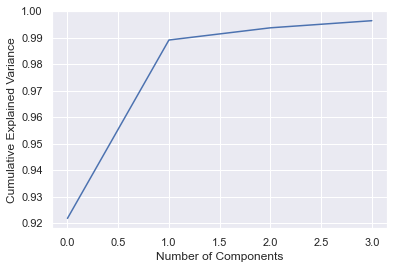

In [17]:
### PCA on numerical variables
pca = PCA(n_components=4)
nums_part = train_df[num_list].reset_index(drop=True)
nums_part = nums_part.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)
pca.fit(nums_part)
# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
nums_part_pca = pca.transform(nums_part)

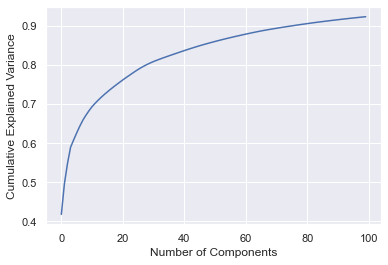

In [18]:
### PCA on categorical variables
pca = PCA(n_components=100)
pca.fit(cates)
# Plot the cumulative explained variance as a function of the number of components
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
cates_pca = pca.transform(cates)

In [19]:
X = pd.concat([pd.DataFrame(nums_part_pca), pd.DataFrame(cates_pca)], axis=1)
y = train_df['isFraud']
X.columns = [x for x in range(len(X.columns.tolist()))]

# #Raw Ratio
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
# X_train = X_train.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)
# X_test = X_test.fillna(0).replace(-np.Inf, -10).replace(np.Inf, 10)

### Model Selection

#### Naive Bayes (Baseline Model)

In [22]:
from sklearn.model_selection import KFold
def kfold_cv(k, X, y, model):
    kf = KFold(n_splits=k)
    fold = 0
    clf = model
    acc_lst, pre_lst, rec_lst, f1_score_lst= [],[],[],[]
    for train_index, test_index in kf.split(X):
        #Split data        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        score = precision_recall_fscore_support(y_test, y_pred, average='binary')
        acc_lst.append(accuracy)
        pre_lst.append(score[0])
        rec_lst.append(score[1])
        f1_score_lst.append(score[2])
        fold+=1
        
    accuracy = np.mean(acc_lst)
    precision = np.mean(pre_lst)
    recall = np.mean(rec_lst)
    f1 = np.mean(f1_score_lst)
    print('Accuracy = ' + str(round(accuracy, 3)))
    print('Precision = ' + str(round(precision, 3)))
    print('Recall = ' + str(round(recall, 3)))
    print('F1 = ' + str(round(f1, 3)))
          
    return accuracy, precision, recall, f1

### Naive Bayes (Baseline Model)

In [23]:
nb_model = BernoulliNB()
accuracy, precision, recall, f1 = kfold_cv(10, X, y, nb_model)

Accuracy = 0.653
Precision = 0.5
Recall = 0.345
F1 = 0.408


#### Random Forest

In [24]:
rf_model = RandomForestClassifier(random_state=42)
accuracy, precision, recall, f1 = kfold_cv(10, X, y, rf_model)

Accuracy = 0.76
Precision = 0.5
Recall = 0.375
F1 = 0.428


#### LightGBM

In [25]:
lgb_model = lgb.LGBMClassifier(random_state=42)
accuracy, precision, recall, f1 = kfold_cv(10, X, y, lgb_model)

Accuracy = 0.753
Precision = 0.5
Recall = 0.369
F1 = 0.425


#### XGBoost

In [26]:
xgb_model = xgb.XGBClassifier(random_state=42)
accuracy, precision, recall, f1 = kfold_cv(10, X, y, xgb_model)

Accuracy = 0.763
Precision = 0.5
Recall = 0.374
F1 = 0.428
